In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch.nn as nn
import torch
from tqdm.autonotebook import tqdm
import seaborn as sns
import os, sys

from matplotlib.lines import Line2D
from collections import defaultdict
from matplotlib.colors import LinearSegmentedColormap
# Root project
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added to sys.path:", project_root)

from envs import *
from basal_ganglia import *
from stn_gpe import *

# filter warnings
import warnings
warnings.filterwarnings("ignore")
import pickle

C:\Users\chari\AppData\Local\Temp\ipykernel_18020\1028357622.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Project root added to sys.path: c:\Myfiles\Workshop_comp_modelling\FromSTNSpikesToChoices


In [2]:
yaml_path = os.path.join(project_root, 'params', 'decision_making_task_params', 'igt_params.yaml')
params = load_yaml(yaml_path)
STN_DATA_path = os.path.join(project_root, 'params', 'stn_gpe_params', 'params_std_DBS.yaml')

## Hyperparameters


In [3]:
TRIALS = params['TRIALS']
EPOCHS = params['EPOCHS']
NUM_BINS = params['NUM_BINS']
LR = params['LR']
NUM_ARMS = params['NUM_ARMS']
SCALING_FACTOR = params['SCALING_FACTOR']
REW_STD = 0
LOSS_STD = 0

## Simulation

In [4]:
env = IGTEnv(mean_reward=np.array([100,100,50,50])/SCALING_FACTOR,
             std_reward=np.array([REW_STD,REW_STD,REW_STD,REW_STD])/SCALING_FACTOR,
             mean_loss=np.array([-250,-1250,-50,-250])/SCALING_FACTOR,
             std_loss=np.array([LOSS_STD,LOSS_STD,LOSS_STD,LOSS_STD])/SCALING_FACTOR)

In [5]:

reward_monitor, arm_chosen_monitor, avg_counts,ip_monitor, dp_monitor, ep_monitor, _= train(env, 
                                                      trails = TRIALS, 
                                                      epochs = EPOCHS, 
                                                      lr = LR, 
                                                      bins = NUM_BINS,
                                                      STN_data = STN_DATA_path, 
                                                      d1_amp=0.5,
                                                      d2_amp=0.01, #0.035, #1
                                                      gpi_threshold=0.15,#0.18,
                                                      max_gpi_iters=50,
                                                      del_lim=None, train_IP = False, 
                                                      del_med = None, printing = False ,
                                                      gpi_mean= 1, ep_0 = 0.25)


Running STN-GPe system


  0%|          | 0/50000 [00:00<?, ?it/s]

tensor(0.0484, dtype=torch.float64)
tensor(1., dtype=torch.float64) tensor(0.0237, dtype=torch.float64)
tensor(0.9997) tensor(0.0221)


  0%|          | 0/100 [00:00<?, ?it/s]

## Analysis

In [6]:
A_picks = avg_counts[0]
B_picks = avg_counts[1]
C_picks = avg_counts[2]
D_picks = avg_counts[3]

Avg_A_picks = torch.mean(A_picks, dim = 0)
Avg_B_picks = torch.mean(B_picks, dim = 0)
Avg_C_picks = torch.mean(C_picks, dim = 0)
Avg_D_picks = torch.mean(D_picks, dim = 0)

IGT_score = torch.mean(torch.add(C_picks, D_picks) - torch.add(A_picks, B_picks), dim = 0).squeeze().numpy()
IGT_dev = torch.std(torch.add(C_picks, D_picks) - torch.add(A_picks, B_picks), dim = 0)/torch.sqrt(torch.tensor(EPOCHS, dtype = torch.float32))
IGT_dev = IGT_dev.squeeze().numpy()

print(f'IGT score: {IGT_score} with SE of {IGT_dev}')

IGT score: [-13.9   -5.5   -0.42  -0.62  -6.38] with SE of [1.1460516 1.6537377 1.7226465 1.7876558 1.6145036]


In [7]:
A_picks = avg_counts[0]
B_picks = avg_counts[1]
C_picks = avg_counts[2]
D_picks = avg_counts[3]

Avg_A_picks = torch.mean(A_picks, dim = 0)
Avg_B_picks = torch.mean(B_picks, dim = 0)
Avg_C_picks = torch.mean(C_picks, dim = 0)
Avg_D_picks = torch.mean(D_picks, dim = 0)

IP_A = torch.mean(ip_monitor[0], dim = 0).detach().numpy()
IP_B = torch.mean(ip_monitor[1], dim = 0).detach().numpy()
IP_C = torch.mean(ip_monitor[2], dim = 0).detach().numpy()
IP_D = torch.mean(ip_monitor[3], dim = 0).detach().numpy()

DP_A = torch.mean(dp_monitor[0], dim = 0).detach().numpy()
DP_B = torch.mean(dp_monitor[1], dim = 0).detach().numpy()
DP_C = torch.mean(dp_monitor[2], dim = 0).detach().numpy()
DP_D = torch.mean(dp_monitor[3], dim = 0).detach().numpy()

IGT_score = torch.mean(torch.add(C_picks, D_picks) - torch.add(A_picks, B_picks), dim = 0)
IGT_dev = torch.std(torch.add(C_picks, D_picks) - torch.add(A_picks, B_picks), dim = 0)/torch.sqrt(torch.tensor(EPOCHS, dtype = torch.float32))

IP_all = np.array([IP_A[:,0],IP_B[:,0],IP_C[:,0],IP_D[:,0]])
IP_Var = np.std(IP_all,axis = 0 )

## Results

tensor([[-13.9000],
        [ -5.5000],
        [ -0.4200],
        [ -0.6200],
        [ -6.3800]]) tensor([[1.1461],
        [1.6537],
        [1.7226],
        [1.7877],
        [1.6145]])


Text(0, 0.5, 'IGT Score')

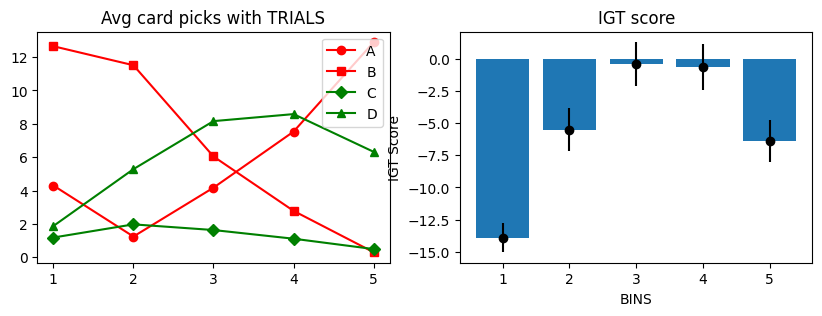

In [8]:
BINS = np.arange(5) + 1

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(BINS,Avg_A_picks, label = 'A', color = 'red', marker = 'o')
plt.plot(BINS,Avg_B_picks, label = 'B', color = 'red', marker = 's')
plt.plot(BINS,Avg_C_picks, label = 'C', color = 'green', marker = 'D')
plt.plot(BINS,Avg_D_picks, label = 'D', color = 'green', marker = '^')
plt.title('Avg card picks with TRIALS')
plt.legend(loc = 'upper right')

plt.subplot(122)
plt.bar(BINS, IGT_score.reshape(5))
print(IGT_score, IGT_dev)
plt.errorbar(BINS, IGT_score.reshape(5), yerr= IGT_dev.reshape(5), fmt='o', color = 'black')
plt.title(f'IGT score')
plt.xlabel('BINS')
plt.ylabel('IGT Score')


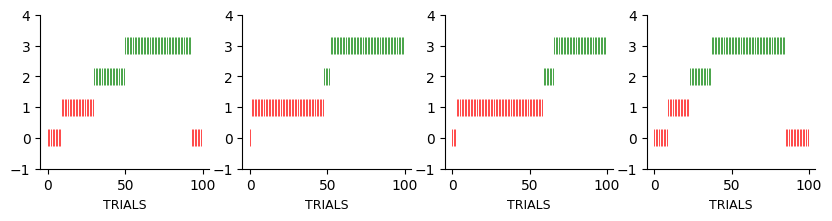

In [9]:
random_pick = np.random.choice(np.arange(EPOCHS), size = 4)

plt.figure(figsize=(10,2))
for i in range(4):
    plt.subplot(1,4,i+1)
    colors = np.where(np.isin(arm_chosen_monitor[random_pick[i]],[0,1]), 'r', 'g')
    # lenght of marker
    plt.scatter(np.arange(TRIALS), arm_chosen_monitor[random_pick[i]], c = colors, s = 150, marker = '|', linewidth = 0.5,)
    plt.ylim(-1,4)
    plt.xlabel('TRIALS', fontsize = 9)

# remove right border
for ax in plt.gcf().axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
